In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samtakoi","key":"a67e8370327483f7a36bf8b25f74e62b"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d soheiltehranipour/apple-stock-20132018

Dataset URL: https://www.kaggle.com/datasets/soheiltehranipour/apple-stock-20132018
License(s): CC0-1.0
  0% 0.00/7.40k [00:00<?, ?B/s]
100% 7.40k/7.40k [00:00<00:00, 14.2MB/s]


In [5]:
from IPython.core.display import clear_output
!unzip '/content/apple-stock-20132018.zip' -d '/content/apple'
clear_output()

# Взял датасет с акциями компании Apple

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [7]:
df = pd.read_csv('/content/apple/AAPL.xls')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Open    1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.head()

,Date,Open
0,2013-01-02,79.117142
1,2013-01-03,78.268570
2,2013-01-04,76.709999
3,2013-01-07,74.571426
4,2013-01-08,75.601425


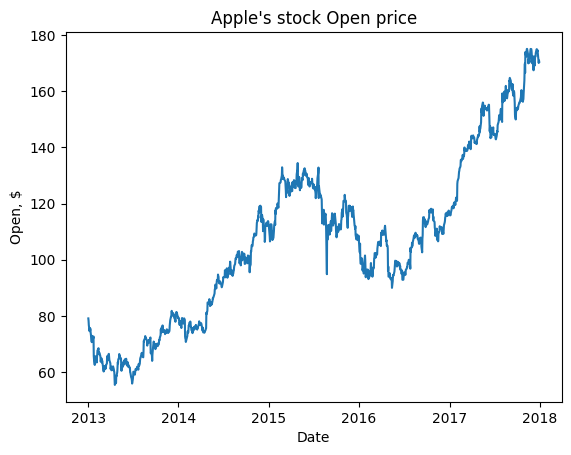

In [12]:
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open, $')

plt.title('Apple\'s stock Open price')
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

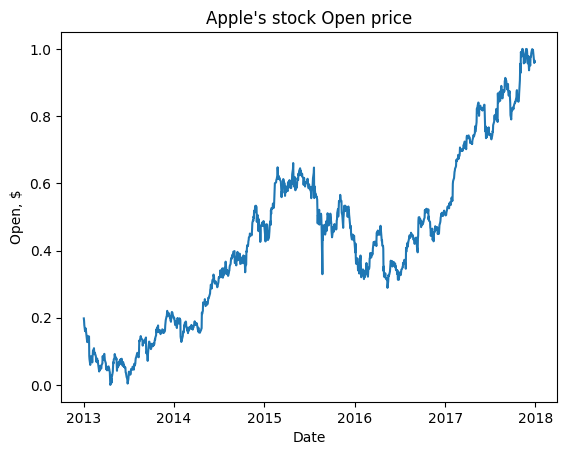

In [14]:
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open, $')

plt.title('Apple\'s stock Open price')
plt.show()

In [15]:
test_ratio = 0.2
split_row = len(df) - int(test_ratio*len(df))
train_df = df.iloc[:split_row]
test_df = df.iloc[split_row:]

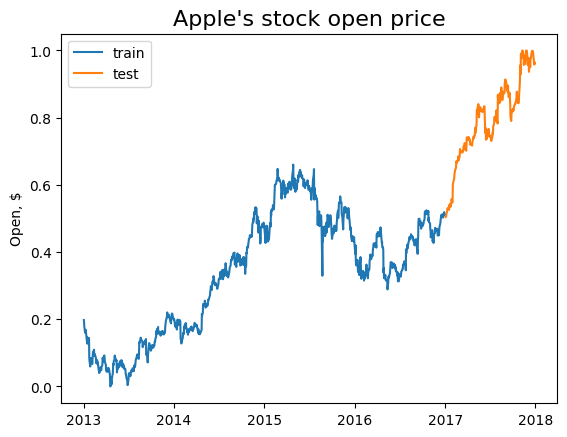

In [16]:
fig, ax = plt.subplots(1)
ax.plot(train_df['Date'], train_df['Open'], label='train')
ax.plot(test_df['Date'], test_df['Open'], label='test')
ax.set_ylabel('Open, $')
ax.set_title('Apple\'s stock open price', fontsize=16)
ax.legend()

fig.show()

In [17]:
train_data = train_df['Open'].values
test_data = test_df['Open'].values

In [18]:
window = 50

X = []
y = []

for i in range(len(train_data)-window):
    X.append(train_data[i:i+window])
    y.append(train_data[i+window])

X = np.array(X)
y = np.array(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
def build_model():
  input = Input(shape=(window, 1))
  hidden = LSTM(100)(input)
  output = Dense(1, activation='linear')(hidden)

  model = Model(inputs=input, outputs=output)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])

  return model

In [21]:
model = build_model()

checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=20, verbose=1)

tensorboard = TensorBoard(log_dir="./logs")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=32,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard
    ],
)

Epoch 1/500
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0445 - mae: 0.1609
Epoch 1: val_loss improved from inf to 0.00211, saving model to ./best-model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0424 - mae: 0.1556 - val_loss: 0.0021 - val_mae: 0.0388
Epoch 2/500
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021 - mae: 0.0382
Epoch 2: val_loss improved from 0.00211 to 0.00100, saving model to ./best-model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0021 - mae: 0.0380 - val_loss: 9.9683e-04 - val_mae: 0.0242
Epoch 3/500
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.3048e-04 - mae: 0.0231
Epoch 3: val_loss improved from 0.00100 to 0.00073, saving model to ./best-model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.2043e-04 - mae: 0.0229 - val_loss: 7.2628e-04 - val_mae: 0.0197
Epoch 4/500
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.3229e-04 - mae: 0.0197
Epoch 4: val_loss improved from 0.00073 to 0.00070, saving model to ./best-model.

In [22]:
best_model = load_model(checkpoint_path)
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

In [23]:
X_val = []
y_val = []

for i in range(len(test_data)-window):
    X_val.append(test_data[i:i+window])
    y_val.append(test_data[i+window])

X_val = np.array(X_val)
y_val = np.array(y_val)

In [24]:
predictions = best_model.predict(X_val)
inv_predictions = scaler.inverse_transform(predictions)
inv_real = scaler.inverse_transform(y_val.reshape(-1, 1))

predictions = inv_predictions.reshape(1, -1)[0]
real_values = inv_real

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


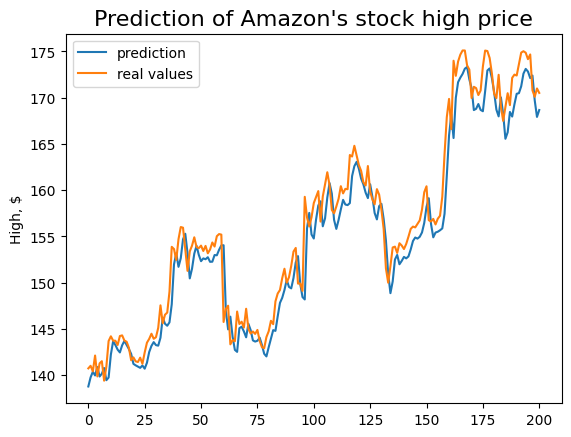

In [25]:
fig, ax = plt.subplots(1)
ax.plot(predictions, label='prediction')
ax.plot(real_values, label='real values')
ax.set_ylabel('High, $')
ax.set_title('Prediction of Amazon\'s stock high price', fontsize=16)
ax.legend()

fig.show()

In [26]:
print('Validation MAE: %.3f' % mean_absolute_error(real_values, predictions))

Validation MAE: 1.877


## В целом средняя абсолютная ошибка получилось небольшой относительно всего датасета, а значит можно считать все получилось удачно!